#选择1个数据集进行频繁模式和关联规则挖掘

##分析报告

###一、数据

####1.1 数据集选择 Wine Reviews：winemag-data-130k-v2.csv 数据集包括（国家，酒的评分）

####1.2 编程语言：python

####1.3 导入所需各类依赖包

In [115]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
lift =[]
KULC =[]
IR = []
support = []

###二、数据分析要求
####2.1 对数据集进行处理，转换成适合进行关联规则挖掘的形式

加载数据集, 对于该数据集由于其他的标称属性值都比较独特，这里我们选取标称属性country和数值属性points为例做分析
<p> 对于points我们做了如下处理，我们将酒的评分分为了5级：
    <p>0：0-19分 1：20-39分 2：40-59分 3：60-79分 4：80-99分

In [116]:
def load_data_set():
    csv_file = csv.reader(open('winemag-data-130k-v2.csv', encoding='utf-8')) #读取数据集
    for row in csv_file:
        llist = []
        if(row[4] == 'points'): #对数据集进行处理（选取points和country为例）
            continue
        if(row[1] != ""):
            llist.append(row[1])
            if(row[4] != ""):
                llist.append(int(float(row[4])/20)) #对points进行分级
        data_set.append(llist)
    return data_set

####2.2 找出频繁模式
<p>这里使用frozenset不可变集合是为了后续计算支持度字典是将集合作为键。
<p>输出为所有的1-项集

In [117]:
# 通过扫描数据集创建候选1-项集C1
def create_C1(data_set):
    C1 = set()
    for t in data_set:
        for item in t:
            item_set = frozenset([item])
            C1.add(item_set)
    return C1

data_set = []
data_set = load_data_set()
print(create_C1(data_set))

{frozenset({'Peru'}), frozenset({'England'}), frozenset({'Macedonia'}), frozenset({'Slovakia'}), frozenset({'Romania'}), frozenset({'Croatia'}), frozenset({'Austria'}), frozenset({'Australia'}), frozenset({'Hungary'}), frozenset({'Bulgaria'}), frozenset({'Slovenia'}), frozenset({'Spain'}), frozenset({'South Africa'}), frozenset({'Luxembourg'}), frozenset({'Germany'}), frozenset({'France'}), frozenset({'Georgia'}), frozenset({'Ukraine'}), frozenset({'India'}), frozenset({'Uruguay'}), frozenset({'Moldova'}), frozenset({'Armenia'}), frozenset({'Cyprus'}), frozenset({'Bosnia and Herzegovina'}), frozenset({'Czech Republic'}), frozenset({'Lebanon'}), frozenset({'Chile'}), frozenset({'Morocco'}), frozenset({'Turkey'}), frozenset({'Italy'}), frozenset({5}), frozenset({4}), frozenset({'Canada'}), frozenset({'Argentina'}), frozenset({'Switzerland'}), frozenset({'Egypt'}), frozenset({'Greece'}), frozenset({'Serbia'}), frozenset({'US'}), frozenset({'Brazil'}), frozenset({'Israel'}), frozenset({'Po

<p>这里使用Apriori属性即先验剪枝原则：任一频繁项的所有非空子集也必须是频繁的。也就是当生成k项候选集的时候，如果候选集中的元素不在k-1项频繁集中，则该元素一定不是频繁集，这个时候不需要计算支持度，直接去除即可。

In [118]:
# 判断常用候选k项集是否满足Apriori属性
def is_apriori(Ck_item, Lksub1):
    for item in Ck_item:
        sub_Ck = Ck_item - frozenset([item])
        if sub_Ck not in Lksub1:
            return False
    return True

<p>** 连接定理 **
<P>若有两个k-1项集，每个项集按照“属性-值”（一般按值）的字母顺序进行排序。如果两个k-1项集的前k-2个项相同，而最后一个项不同，则证明它们是可连接的，即这个k-1项集可以联姻，即可连接生成k项集。例如有两个3项集：{a, b, c} {a, b, d}，这两个3项集就是可连接的，它们可以连接生成4项集｛a, b, c, d｝。又如两个3项集｛a, b, c｝｛a, d, e｝，这两个3项集显示是不能连接生成3项集的。
<p>为了寻找频繁k项集，首先生成一个潜在频繁k项集构成的候选项集：
<p>1、从2项集开始循环，由频繁k-1项集生成频繁频繁k项集。频繁k-1项集生成2项子集，这里的2项指的生成的子集中有两个k-1项集。例如有3个2项频繁集｛a, b｝｛b, c｝｛c, f｝，则它所有的2项子集为{{a, b} {b, c}} {{a, b} {e, f}} {{b, c} {c, f}}
<p>2、对上述生成的2项子集中的两个项集根据连接定理进行连接，生成k项集。接着对k项集中的每个项集根据上述的Apriori属性舍弃掉子集不是频繁项集即不在频繁k-1项集中的项集。
    
<p>由于连接步生成的Ck是Lk的超集，包含所有的频繁项集Lk，同时也可能包含一些非频繁项集。可以利用前述Apriori属性行剪枝以压缩数据规模。比如，如果候选k项集Ck的k-1项子集不在Lk-1中，那么该子集不可能是频繁项集，可以直接删除。


In [119]:
# 创建ck，一个包含所有常见的候选k项集的集合
def create_Ck(Lksub1, k):
    Ck = set()
    len_Lksub1 = len(Lksub1)
    list_Lksub1 = list(Lksub1)
    for i in range(len_Lksub1):
        for j in range(1, len_Lksub1):
            l1 = list(list_Lksub1[i])
            l2 = list(list_Lksub1[j])
            l1.sort()
            l2.sort()
            if l1[0:k-2] == l2[0:k-2]:
                Ck_item = list_Lksub1[i] | list_Lksub1[j]
                # pruning(剪枝)
                if is_apriori(Ck_item, Lksub1):
                    Ck.add(Ck_item)
    return Ck

<p>** 从候选项集中选出频繁项集 **
    <p>扫描数据库，计算上述第2步中过滤后的k项集的支持度，舍弃掉支持度小于阈值的项集，生成频繁k项集。
    <p>我们需要从初始的候选项集中计算k项频繁项集，所以这里封装函数用于每次计算频繁项集及支持度，当候选项集中集合中的每个元素都存在事务记录集合中是计数并保存到字典中，计算支持度后输出频繁项集和支持度。

In [120]:
# 通过从ck执行删除策略生成Lk。
def generate_Lk_by_Ck(data_set, Ck, min_support, support_data):
    Lk = set()
    item_count = {}
    for t in data_set:
        for item in Ck:
            if item.issubset(t):
                if item not in item_count:
                    item_count[item] = 1
                else:
                    item_count[item] += 1
    t_num = float(len(data_set))
    for item in item_count:
        if (item_count[item] / t_num) >= min_support:
            Lk.add(item)
            support_data[item] = item_count[item] / t_num
    return Lk

In [121]:
# 生成所有频繁项集
def generate_L(data_set, k, min_support):
    support_data = {}
    C1 = create_C1(data_set)
    L1 = generate_Lk_by_Ck(data_set, C1, min_support, support_data)
    Lksub1 = L1.copy()
    L = []
    L.append(Lksub1)
    for i in range(2, k+1):
        Ci = create_Ck(Lksub1, i)
        Li = generate_Lk_by_Ck(data_set, Ci, min_support, support_data)
        Lksub1 = Li.copy()
        L.append(Lksub1)
    return L, support_data

####2.3 生成关联规则，计算其支持度和置信度（关联规则导出见后序代码）
<p>生成关联规则，筛选符合规则的频繁集计算置信度，满足最小置信度的关联规则添加到列表
####2.4 对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种
<p>这里采用了3中评价指标分别是：Lift、KULC、IR

In [122]:
# 生成关联规则并通过三种方法对关联规则进行评估
def generate_big_rules(L, support_data, min_conf):
    big_rule_list = []
    sub_set_list = []
    for i in range(0, len(L)):
        for freq_set in L[i]:
            for sub_set in sub_set_list:
                if sub_set.issubset(freq_set):
                    conf = support_data[freq_set] / support_data[freq_set - sub_set]
                    big_rule = (freq_set - sub_set, sub_set, conf)
                    if conf >= min_conf and big_rule not in big_rule_list:
                        lift.append(support_data[freq_set]/(support_data[sub_set]*support_data[freq_set-sub_set]))
                        KULC.append((support_data[freq_set]/support_data[sub_set]+support_data[freq_set]/support_data[freq_set-sub_set])/2)
                        IR.append((support_data[freq_set]/support_data[freq_set-sub_set])/support_data[freq_set]/support_data[sub_set])
                        big_rule_list.append(big_rule)
            sub_set_list.append(freq_set)
    return big_rule_list


<p>** 主函数 **
<p>打印所有的频繁项集及其支持度值

In [123]:
#主函数
if __name__ == "__main__":
    conf_set = []
    support_set = []
    data_set = []
    data_set = load_data_set()

In [124]:
    #这里给出最小支持度为0.05，最小置信度为0.7
    L, support_data = generate_L(data_set, k=2, min_support=0.05)
    big_rules_list = generate_big_rules(L, support_data, min_conf=0.7)
    for Lk in L:
        print("*" * 50)
        print("frequent " + str(len(list(Lk)[0])) + "-itemsets\t\tsupport")
        print("*" * 50)
        for freq_set in Lk:
            print(str(freq_set) + "\t" + str(support_data[freq_set]))

**************************************************
frequent 1-itemsets		support
**************************************************
frozenset({'Spain'})	0.05112678982234498
frozenset({'Italy'})	0.15034122996668486
frozenset({'France'})	0.16998407337021335
frozenset({'US'})	0.41935508690400164
frozenset({4})	0.9993690900277754
**************************************************
frequent 2-itemsets		support
**************************************************
frozenset({'France', 4})	0.1699225211778012
frozenset({'US', 4})	0.4193243108077956
frozenset({4, 'Spain'})	0.05112678982234498
frozenset({4, 'Italy'})	0.1503104538704788


<p>打印关联规则及对规则的各评价结果, 结果输出到txt文件中

In [125]:
    # 打印(生成generate_rule.txt)关联规则及对规则的各评价结果
    print("*" * 50)
    print("\t\tBig Rules")
    print("*" * 50)
    i = 0
    
    file = open("generate_rules.txt", "a", encoding="utf-8")
    for item in big_rules_list:
        print(item[0], "=>", item[1], "conf: ", item[2])
        file.write(str(item[0]) + " => " + str(item[1]) + " conf: " + str(item[2]) + '\n')
        # 取出频繁2项集confidence集
        conf_set.append(item[2])
        print("lift：", lift[i])
        file.write("lift：" + str(lift[i]) + '\n')
        print("KULC：", KULC[i])
        file.write("KULC：" + str(KULC[i]) + '\n')
        print("IR：", IR[i])
        file.write("IR：" + str(IR[i]) + '\n')
        i = i+1
    file.close()

**************************************************
		Big Rules
**************************************************
frozenset({'France'}) => frozenset({4}) conf:  0.9996378943556784
lift： 1.0002689740262984
KULC： 0.5848338445132564
IR： 5.886618013274712
frozenset({'US'}) => frozenset({4}) conf:  0.9999266108909438
lift： 1.0005578728307005
KULC： 0.7097578223021727
IR： 2.386119399810623
frozenset({'Spain'}) => frozenset({4}) conf:  1.0
lift： 1.0006313082709082
KULC： 0.5255795332938125
IR： 19.571565352487315
frozenset({'Italy'}) => frozenset({4}) conf:  0.9997952917093144
lift： 1.0004264707461856
KULC： 0.5751003189062628
IR： 6.655734481436961


####2.5 对挖掘结果进行分析
<p>** 对上述关联规则评价 **
    
<p>1、Lift评价指标公式为：P(B|A)/P(B)
    <p>称为A条件对于B事件的提升度，如果该值=1，说明两个条件没有任何关联；如果<1，说明A条件(或者说A事件的发生)与B事件是相斥的；>1说明有效，在事件A发生时事件B发生，比直接推荐事件B，效果更好；但是一般在数据挖掘中当提升度大于3时，我们才承认挖掘出的关联规则是有价值的，所以由上述得到的Lift值可以看出：对于红酒的产国为：France、US、Spain、Italy时可以得到红酒的评分为4等级即80-99分这一关联是成立的。
        
<p>提升度是一种比较简单地判断手段，在实际应用中它受零事务的影响较大，零事务在本例中可以理解为既不知道红酒产国也不知道其评分的事务，在现实中,这个值往往其实是很大的。如果保持其他数据不变，把事务总数扩大，那么计算出的提升度就会明显增大，此时的零事务也会很大，可见提升度是与零事务有关的。
<p>因此** 根据教材中说法，常用的评价方法除了提升度外，还可以使用 KULC度量 + 不平衡比(IR)。这一方法可以有效的降低零事务造成的影响。 
<p>2、KULC评价指标公式为：0.5*P(B|A)+0.5*P(A|B)
该公式表示将两种事件作为条件的置信度的均值，避开了支持度的计算，因此不会受零和事务的影响。其取值为0-1之间，值越大说明两者相关性越大。 
<p>3、IR评价指标公式为：P(B|A)/P(A|B) 指示事务的关联关系平衡状态
<p>根据** KULC度量 + 不平衡比(IR) **可以看出
   <p>KULC值从大到小依次为：frozenset({'US'}) => frozenset({4}) > frozenset({'France'}) => frozenset({4}) > frozenset({'Italy'}) => frozenset({4}) > frozenset({'Spain'}) => frozenset({4})
   <p>也就是说红酒产国为US的红酒评分的80-99的相关性最高
   <p>IR值从大到小依次为：frozenset({'Spain'}) => frozenset({4}) > frozenset({'Italy'}) => frozenset({4}) > frozenset({'France'}) => frozenset({4}) > frozenset({'US'}) => frozenset({4})
   <p>从结果可以看出，frozenset({'US'}) => frozenset({4})是最平衡的，也就是说红酒产国为US可以推出红酒评分为80-99的相关性且红酒评分为80-99分也可以推出红酒产国为US；而对于frozenset({'Spain'}) => frozenset({4})是相当不平衡的，IR值为19.57。

####2.6 对挖掘结果可视化
<p>** 1、画出红酒产国与红酒评分的分别的频率直方图 **

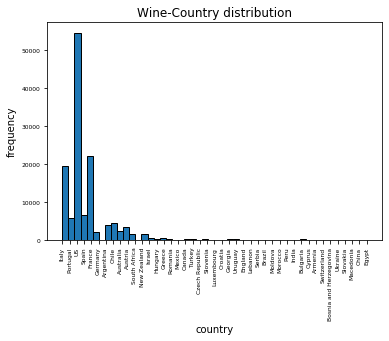

In [126]:
    #数据读取
    wine = pd.DataFrame(pd.read_csv('winemag-data-130k-v2.csv'))
    
    #country属性直方图
    plt.hist(x=wine['country'].dropna(), bins=50, edgecolor='black')
    # 添加x轴和y轴标签
    plt.xlabel('country')
    plt.ylabel('frequency')
    # 添加标题
    plt.title('Wine-Country distribution')
    plt.xticks(rotation=90)
    plt.tick_params(labelsize=6)
    plt.show()

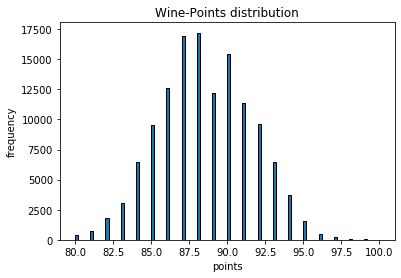

In [127]:
    #points属性直方图
    plt.hist(x=wine['points'], bins=100, edgecolor='black')
    # 添加x轴和y轴标签
    plt.xlabel('points')
    plt.ylabel('frequency')
    # 添加标题
    plt.title('Wine-Points distribution')
    plt.show()

<p>** 2、画出红酒产国与红酒评分散点图 **

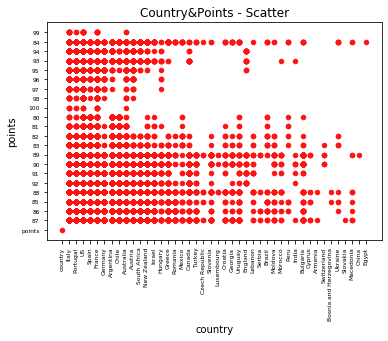

In [128]:
    csv_file = csv.reader(open('winemag-data-130k-v2.csv', encoding='utf-8')) #读取数据集
    country = []
    points = []
    for row in csv_file:
        if(row[1] != ""):
            country.append(row[1])
            if(row[4] != ""):
                points.append(row[4])
    plt.title("Country&Points - Scatter")
    plt.xlabel('country')
    plt.xticks(rotation=90)
    plt.tick_params(labelsize=6)
    plt.ylabel('points')
    plt.scatter(country, points, s=20, c="#ff1212", marker='o')
    plt.show()

<p>** 3、（红酒产国及评分的）support和confidence散点图 **

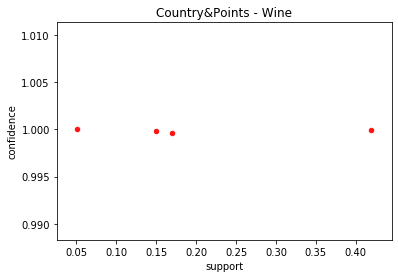

In [129]:
    # 取出频繁2项集support值
    for Lk in L:
        if (str(len(list(Lk)[0])) == '2'):
            for freq_set in Lk:
                support_set.append(support_data[freq_set])
                
    # 画（酒国家及酒评分的）support和confidence散点图
    plt.title("Country&Points - Wine")
    plt.xlabel('support')
    plt.ylabel('confidence')
    plt.scatter(support_set, conf_set, s=20, c="#ff1212", marker='o')
    plt.show()

<p>** 4-1、Lift评估结果与support散点图 **

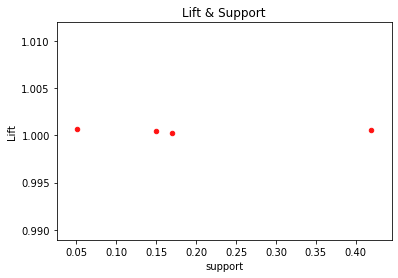

In [130]:
    plt.title("Lift & Support")
    plt.xlabel('support')
    plt.ylabel('Lift')
    plt.scatter(support_set, lift, s=20, c="#ff1212", marker='o')
    plt.show()

<p>** 4-2、Lift评估结果与confidence散点图 **

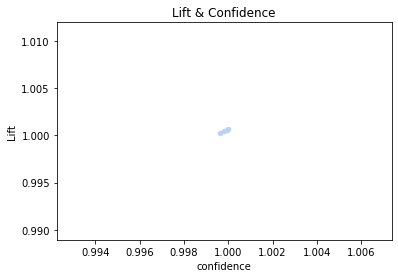

In [131]:
    # Lift评估结果与confidence散点图
    plt.title("Lift & Confidence")
    plt.xlabel('confidence')
    plt.ylabel('Lift')
    plt.scatter(conf_set, lift, s=20, c="#B9D3EE", marker='o')
    plt.show()

<p>** 5-1、KULC评估结果与support散点图 **

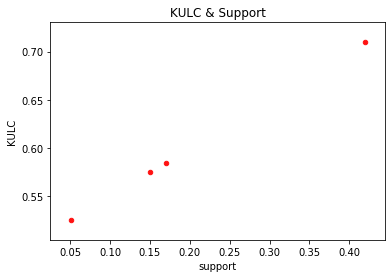

In [132]:
    # KULC评估结果与support散点图
    plt.title("KULC & Support")
    plt.xlabel('support')
    plt.ylabel('KULC')
    plt.scatter(support_set, KULC, s=20, c="#ff1212", marker='o')
    plt.show()

<p>** 5-2、KULC评估结果与confidence散点图 **

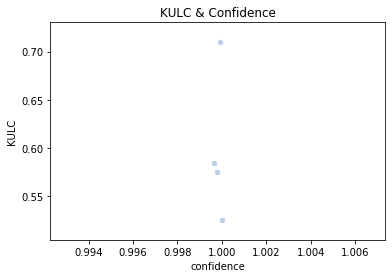

In [133]:
    # KULC评估结果与confidence散点图
    plt.title("KULC & Confidence")
    plt.xlabel('confidence')
    plt.ylabel('KULC')
    plt.scatter(conf_set, KULC, s=20, c="#B9D3EE", marker='o')
    plt.show()

<p>** 6-1、IR评估结果与support散点图 **

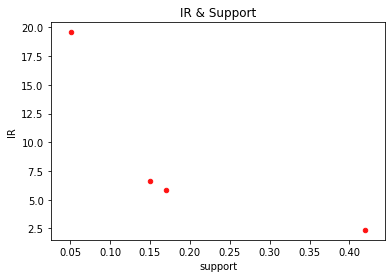

In [134]:
    # IR评估结果与support散点图
    plt.title("IR & Support")
    plt.xlabel('support')
    plt.ylabel('IR')
    plt.scatter(support_set, IR, s=20, c="#ff1212", marker='o')
    plt.show()

<p>** 6-2、IR评估结果与confidence散点图 **

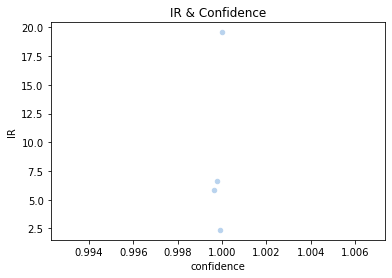

In [135]:
    # IR评估结果与confidence散点图
    plt.title("IR & Confidence")
    plt.xlabel('confidence')
    plt.ylabel('IR')
    plt.scatter(conf_set, IR, s=20, c="#B9D3EE", marker='o')
    plt.show()

<p>** 7、支持度、置信度、关联规则评价结果直方图 **

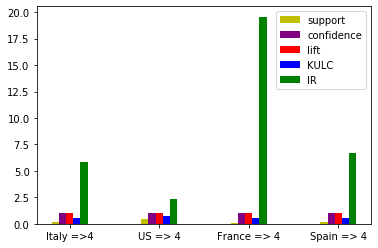

In [136]:
    # 支持度、置信度、关联规则评价结果直方图
    name_list = ['Italy =>4', 'US => 4', 'France => 4', 'Spain => 4']
    total_width, n = 0.4, 5
    width = total_width / n
    x = list(range(len(support_set)))
    plt.bar(x, support_set, width=width, label="support", fc='y')
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, conf_set, width=width, label="confidence", fc='purple')
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, lift, width=width, label="lift", fc='r', tick_label=name_list)
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, KULC, width=width, label="KULC", fc='blue')
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, IR, width=width, label="IR", fc='g')
    plt.legend()
    plt.show()
